# Plot

In [11]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append('../../Recast/ATLAS-TOPQ-2019-23_tpT')
from atlas_topq_2019_23_Limits import read_ATLASdata, getSMLO, getKfactor

pd.option_context('display.max_columns', -1)

pd.options.mode.chained_assignment = None #Disable copy warnings
# plt.style.use('fivethirtyeight') #Set style
# mpl.rcParams.update({'figure.figsize' : (15,10)})  #Set general plotting options
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({"savefig.dpi" : 300}) #Figure resolution


#Define plotting style:
sns.set() #Set style
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.colormaps['RdYlBu']

colors = sns.color_palette('Paired')

### Load Recast Data

In [12]:
recastDataAll = pd.read_pickle('../../Recast/ATLAS-TOPQ-2019-23_tpT/pp2tt_formFactors_scan.pcl')
recastDataEFTAll = pd.read_pickle('../../Recast/ATLAS-TOPQ-2019-23_tpT/pp2tt_eft_scan.pcl')

### Get ATLAS data

In [13]:
xsecsObs,smNLO,covMatrix = read_ATLASdata(dataDir='../../Recast/ATLAS-TOPQ-2019-23_tpT/data')
bgError = np.sqrt(covMatrix.diagonal())
atlas_bins = np.array([355.0,381.0,420.0,478.0,549.0,633.0,
                        720.0,836.0,2000.0])
bin_widths  = atlas_bins[1:]-atlas_bins[:-1]
print('Data:',xsecsObs)
print('SM(NLO):\n',smNLO/bin_widths)
print('CovMatrix:')
covMatrix

Data: [1.129501e-02 8.518551e-03 5.196489e-03 2.585358e-03 1.099220e-03
 4.466096e-04 1.558704e-04 7.694208e-06]
SM(NLO):
 [1.16790403e-02 8.82351513e-03 5.49061028e-03 2.77538181e-03
 1.21123052e-03 4.75281936e-04 1.68215336e-04 8.18817615e-06]
CovMatrix:


array([[ 3.81832826e-07,  1.32578400e-09, -1.66344800e-09,
         2.86848800e-12,  3.97951700e-11,  2.33993900e-11,
         4.41265000e-12, -2.61606700e-13],
       [ 1.32578400e-09,  1.54302420e-07,  3.05611000e-10,
        -4.04371100e-10,  1.52182300e-11,  3.08376600e-11,
         4.47543500e-12,  1.50092400e-13],
       [-1.66344800e-09,  3.05611000e-10,  4.51523035e-08,
        -4.28218400e-11, -1.24275800e-10,  7.84641400e-12,
         8.58552700e-13, -4.53217400e-13],
       [ 2.86848800e-12, -4.04371100e-10, -4.28218400e-11,
         1.32802766e-08, -2.65835800e-11, -5.05167500e-11,
         1.00710300e-12,  1.40432400e-13],
       [ 3.97951700e-11,  1.52182300e-11, -1.24275800e-10,
        -2.65835800e-11,  4.50037622e-09, -1.17533100e-11,
        -1.58225900e-11,  1.48251700e-13],
       [ 2.33993900e-11,  3.08376600e-11,  7.84641400e-12,
        -5.05167500e-11, -1.17533100e-11,  1.04776360e-09,
        -4.15263400e-12, -4.32260200e-13],
       [ 4.41265000e-12,  4.475435

### Get SM prediction and k-factor

In [14]:
# ### Load SM prediction (LO)
smLO = getSMLO('../../Recast/ATLAS-TOPQ-2019-23_tpT/sm/sm_atlas_topq_2019_23.pcl')
# ### Load k-factors
kfac = getKfactor(smNLO,smLO)
smNLO = smNLO/bin_widths

### Select parameters

In [15]:
mST = 500.0
mChi = 400.0
yDM = 1.0

recastData = recastDataAll[(recastDataAll['mST'] == mST) & (recastDataAll['mChi'] == mChi) & (recastDataAll['yDM'] == yDM)]
recastDataEFT = recastDataEFTAll[(recastDataEFTAll['mST'] == mST) & (recastDataEFTAll['mChi'] == mChi) & (recastDataEFTAll['yDM'] == yDM)]
mST,mChi,yDM = recastData[['mST','mChi','yDM']].iloc[0]
print(mST,mChi,yDM)
print(len(recastData),len(recastDataEFT))

500.0 400.0 1.0
1 1


### Get signal

In [20]:
binCols = [c for c in recastData.columns 
               if 'bin_' in c.lower() and not 'error' in c.lower()]
bins_left = np.array([eval(c.split('_')[1]) for c in binCols])
bins_right = np.array([eval(c.split('_')[2]) for c in binCols])     
bin_centers = (bins_left+bins_right)/2.0
bin_widths = bins_right-bins_left
cms_bins = np.append(bins_left,bins_right[-1])

signal = list(zip(bins_left,recastData.iloc[0][binCols].values))
signal = np.array(sorted(signal))[:,1]

signalEFT = list(zip(bins_left,recastDataEFT.iloc[0][binCols].values))
signalEFT = np.array(sorted(signalEFT))[:,1]
print('Signal (LO):')
signal/bin_widths


Signal (LO):


array([1.63943741e-06, 1.84706470e-06, 2.20134377e-06, 1.55357415e-06,
       8.62291400e-07, 3.96303076e-07, 1.56020505e-07, 1.77168887e-09])

### Apply k-factors and rescale by bins

In [21]:
signalNLO = signal*kfac/bin_widths
signalEFTNLO = signalEFT*kfac/bin_widths
print('Signal (NLO):')
signalNLO

Signal (NLO):


array([2.90611832e-06, 2.98240113e-06, 3.34872682e-06, 2.18939684e-06,
       1.06708349e-06, 4.02325502e-07, 1.41776158e-07, 1.03817623e-09])

### Plot distribution and data

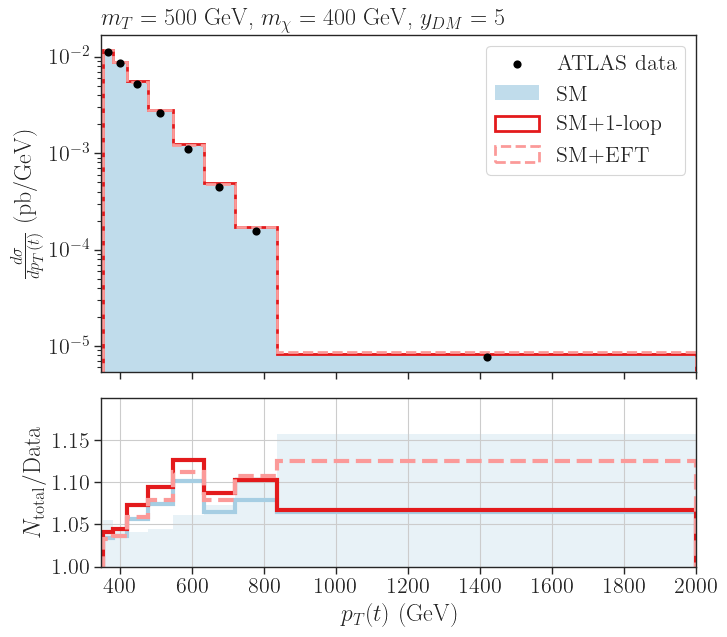

In [18]:
yDM = 5.0/recastData.iloc[0]['yDM']

_, axarr = plt.subplots(2,sharex=True, gridspec_kw = {'height_ratios':[2, 1]},figsize=(7,7))
plt.subplots_adjust(left=0.12, bottom=0.12, right=0.97, top=None, wspace=None, hspace=0.1)

axarr[0].scatter(bin_centers,xsecsObs,label='ATLAS data',linewidth=2,s=15,
c='black',zorder=10)
axarr[0].hist(bin_centers,weights=smNLO,label=r'SM',histtype='step',linewidth=0,bins=cms_bins,color=colors[0],fill=True,alpha=0.7)
axarr[0].hist(bin_centers,weights=smNLO+signalNLO*yDM**2,label=r'SM+1-loop',histtype='step',linewidth=2,bins=cms_bins,color=colors[5])
axarr[0].hist(bin_centers,weights=smNLO+signalEFTNLO*yDM**2,label=r'SM+EFT',histtype='step',linewidth=2,bins=cms_bins,linestyle='dashed',color=colors[4])
axarr[0].set_yscale('log')
# axarr[0].set_ylim(1e-6,2e-2)
axarr[0].legend()
axarr[0].set_xlim(350.,2000.)
# axarr[0].grid()

axarr[1].hist(bin_centers,weights=np.divide(smNLO,xsecsObs),histtype='step',linewidth=3,bins=cms_bins,color=colors[0])
axarr[1].hist(bin_centers,weights=np.divide(smNLO+signalNLO*yDM**2,xsecsObs),histtype='step',linewidth=3,bins=cms_bins,color=colors[5])
axarr[1].hist(bin_centers,weights=np.divide(smNLO+signalEFTNLO*yDM**2,xsecsObs),histtype='step',linewidth=3,bins=cms_bins,color=colors[4],linestyle='dashed')

# axarr[1].bar(x=bins_left, height=np.divide(2*bgError,xsecsObs), bottom=np.divide(smNLO-bgError,xsecsObs), width=bin_widths, align='edge', linewidth=0, color=colors[0], alpha=0.25, zorder=-1, label='uncertainty band')

axarr[1].bar(x=bins_left, height=np.divide(2*bgError,xsecsObs), bottom=np.divide(xsecsObs-bgError,xsecsObs), width=bin_widths, align='edge', linewidth=0, color=colors[0], alpha=0.25, zorder=-1, label='uncertainty band')


axarr[1].set_yticks(np.arange(1.0,1.2,0.05))
axarr[1].set_ylim(1.0,1.2)
axarr[1].grid()

axarr[1].set_xlabel(r'$p_T(t)$ (GeV)')
axarr[0].set_ylabel(r'$\frac{d \sigma}{d p_T(t)}$ (pb/GeV)')
axarr[1].set_ylabel(r'$N_{\rm total}/{\rm Data}$')

axarr[0].set_title(r'$m_T = %1.0f$ GeV, $m_{\chi} = %1.0f$ GeV, $y_{DM} = %1.0f$' %(mST,mChi,yDM),loc='left')
plt.savefig('ATLAS_pTt_mST%i_mChi%i_yDM_%i.png' %(int(mST),int(mChi),int(yDM)))
plt.show()